# zappend Demo

This Notebook demonstrates the two user interfaces of the `zappend` tool, namely the CLI and API with some local NetCDF inputs.

In [1]:
import glob
import math
import os
import os.path
import shutil

import numpy as np
import xarray as xr

First let's define a utility to remove directories:

In [2]:
def rmdir(path: str):
    if os.path.exists(path):
        shutil.rmtree(path)

## Define the inputs

We use Ocean Colour data produced by the [EU HIGHROC Project](https://www.highroc.eu/) as input.

In [3]:
slice_pattern = "inputs/*.nc"

In [4]:
slice_paths = sorted(glob.glob(slice_pattern))[:3]
slice_paths

['inputs\\20230601_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc',
 'inputs\\20230603_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc',
 'inputs\\20230605_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc']

This is how a single slice looks like:

In [5]:
slice_ds = xr.open_dataset(slice_paths[0])
slice_ds

<xarray.Dataset>
Dimensions:  (time: 1, lat: 8640, lon: 3435)
Coordinates:
  * time     (time) datetime64[ns] 2023-06-01
  * lat      (lat) float64 64.0 64.0 64.0 64.0 64.0 ... 56.0 56.0 56.0 56.0 56.0
  * lon      (lon) float64 6.0 6.002 6.004 6.005 6.007 ... 11.99 12.0 12.0 12.0
Data variables:
    SPM      (time, lat, lon) float32 ...
    TUR      (time, lat, lon) float32 ...
    SPM_QI   (time, lat, lon) float32 ...
    TUR_QI   (time, lat, lon) float32 ...
    crs      int32 ...
Attributes: (12/46)
    TileSize:                   540:286
    id:                         20230601_P1D_CMEMS_HROC_L3_transp_BAL_32V_100...
    title:                      CMEMS HR-OC Baltic Sea transparency (spm, tur...
    region:                     BAL
    tile:                       32V
    cmems_product_id:           OCEANCOLOUR_BAL_BGC_HR_L3_NRT_009_202
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    platform:                   Sentinel-2
    sensor:                     MSI
    start_date:                 01-JUN-2023 00:00:00.000000
    stop_date:                  01-JUN-2023 00:00:00.000000

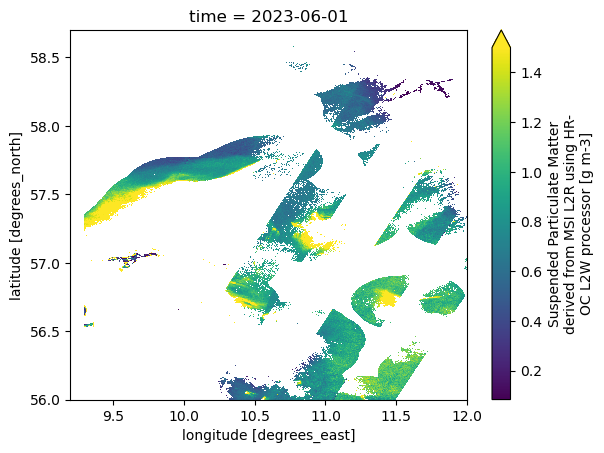

In [6]:
slice_ds.SPM.isel(time=0).sel(lon=slice(9.2, 12), lat=slice(58.7, 56)).plot.imshow(vmax=1.5)

## Define the output

In [7]:
target_path = "target.zarr"

In [8]:
rmdir(target_path)

## Use the zappend CLI

In [9]:
!zappend --help

Usage: zappend [OPTIONS] [SLICES]...

  Create or update a Zarr datacube TARGET from slice datasets SLICES.

  The zappend command concatenates the dataset SLICES along a given append
  dimension, e.g., `"time"` (the default) for geospatial satellite
  observations. Each append step is atomic, that is, the append operation is a
  transaction that can be rolled back, in case the append operation fails.
  This ensures integrity of the target data cube given by TARGET or in CONFIG.

Options:
  -c, --config CONFIG    Configuration JSON or YAML file. If multiple are
                         passed, subsequent configurations are incremental to
                         the previous ones.
  -t, --target TARGET    Target Zarr dataset path or URI. Overrides the
                         'target_dir' configuration field.
  --dry-run              Run the tool without creating, changing, or deleting
                         any files.
  --version              Show version and exit.
  --help-config j

In [10]:
!zappend --version

0.3.1.dev0


Run the tool without any additional configuration:

In [11]:
!zappend -t {target_path} {" ".join(slice_paths)}

Check the target dataset just generated:

In [12]:
target_ds = xr.open_zarr(target_path)
target_ds

<xarray.Dataset>
Dimensions:  (time: 3, lat: 8640, lon: 3435)
Coordinates:
  * lat      (lat) float64 64.0 64.0 64.0 64.0 64.0 ... 56.0 56.0 56.0 56.0 56.0
  * lon      (lon) float64 6.0 6.002 6.004 6.005 6.007 ... 11.99 12.0 12.0 12.0
  * time     (time) datetime64[ns] 2023-06-01 2023-06-03 2023-06-05
Data variables:
    SPM      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    SPM_QI   (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR_QI   (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    crs      int32 ...

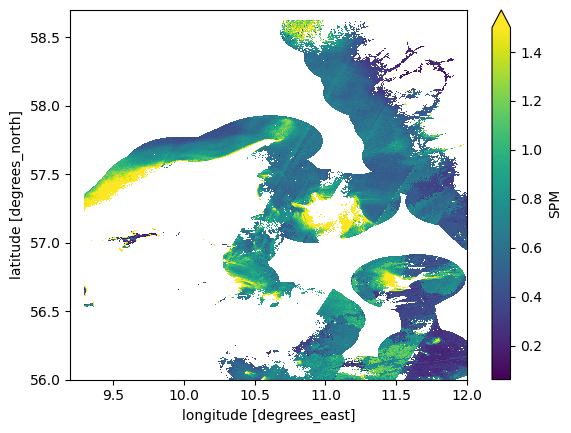

In [13]:
target_ds.SPM.mean("time").sel(lon=slice(9.2, 12), lat=slice(58.7, 56)).plot.imshow(vmax=1.5)

C:\Users\norma\mamba\envs\xcube\Lib\site-packages\dask\array\reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
C:\Users\norma\mamba\envs\xcube\Lib\site-packages\dask\array\reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


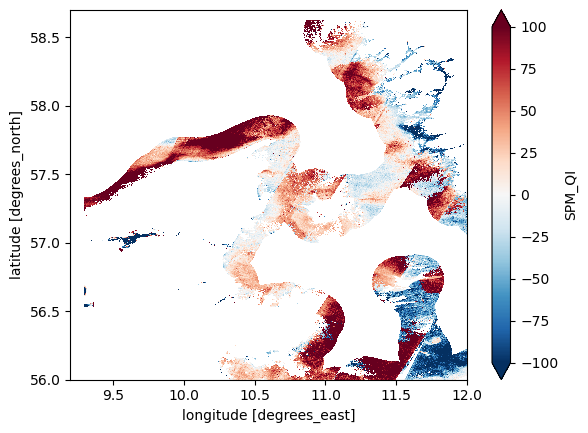

In [14]:
target_ds.SPM_QI.max("time").sel(lon=slice(9.2, 12), lat=slice(58.7, 56)).plot.imshow(vmax=100.0)

## Use the zappend API

Now the same using the API:

In [15]:
from zappend.api import zappend

In [16]:
help(zappend)

Help on function zappend in module zappend.api:

zappend(slices: Iterable[Union[str, zappend.fsutil.fileobj.FileObj, xarray.core.dataset.Dataset, zappend.slice.abc.SliceSource, Callable[[zappend.context.Context], str | zappend.fsutil.fileobj.FileObj | xarray.core.dataset.Dataset | zappend.slice.abc.SliceSource]]], config: zappend.fsutil.fileobj.FileObj | str | dict[str, typing.Any] | list[zappend.fsutil.fileobj.FileObj | str | dict[str, typing.Any]] | tuple[zappend.fsutil.fileobj.FileObj | str | dict[str, typing.Any]] | None = None, **kwargs: Any)
    Robustly create or update a Zarr dataset from dataset slices.
    
    The `zappend` function concatenates the dataset slices from given `slices` along a
    given append dimension, e.g., `"time"` (the default) for geospatial satellite
    observations.
    Each append step is atomic, that is, the append operation is a transaction
    that can be rolled back, in case the append operation fails.
    This ensures integrity of the  target da

In [17]:
# Remove existing target datacube
rmdir(target_path)

Run the tool without any additional configuration:

In [18]:
zappend(slice_paths, target_dir=target_path)

Check the target dataset just generated:

In [19]:
xr.open_zarr(target_path)

<xarray.Dataset>
Dimensions:  (time: 3, lat: 8640, lon: 3435)
Coordinates:
  * lat      (lat) float64 64.0 64.0 64.0 64.0 64.0 ... 56.0 56.0 56.0 56.0 56.0
  * lon      (lon) float64 6.0 6.002 6.004 6.005 6.007 ... 11.99 12.0 12.0 12.0
  * time     (time) datetime64[ns] 2023-06-01 2023-06-03 2023-06-05
Data variables:
    SPM      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    SPM_QI   (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR_QI   (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    crs      int32 ...

Check that time is monotonically increasing:

## zappend Configuration

Now we'll add some configuration. 
You can run `zappend --help-config md` to get configuration help, or do that programmatically:

In [20]:
from IPython.display import Markdown
from zappend.config import get_config_schema

In [21]:
# Uncomment to show configuration refernce
#Markdown(get_config_schema(format="md"))

In [22]:
config = {
    "target_dir": target_path, 
    "variables": {
        # We want the time coordinate variable to use a larger chunk size
        # than the default (= 1 here)
        "time": {
            "encoding": {
                "chunks": [100]
            }
        }
    },
    # Log to the console.
    # Note you could also configure the log output for dask here.
    "logging": {
        "version": 1,
        "formatters": {
            "normal": {
                "format": "%(asctime)s %(levelname)s %(message)s",
                "style": "%"
            }
        },
        "handlers": {
            "console": {
                "class": "logging.StreamHandler",
                "formatter": "normal"
            }
        },
        "loggers": {
            "zappend": {
                "level": "INFO",
                "handlers": ["console"]
            },            
            "notebook": {
                # Will use this one later below
                "level": "INFO",
                "handlers": ["console"]
            }
        }
    }
}

In [23]:
config_path = f"zappend-config.yaml"

In [24]:
import yaml
with open(config_path, mode="w") as f:
    yaml.dump(config, f)

## zappend CLI with Configuration

In [25]:
rmdir(target_path)

In [26]:
!zappend -c {config_path} {" ".join(slice_paths)}

2024-01-31 21:07:55,774 INFO Opening slice dataset from inputs\20230601_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:07:55,794 INFO Creating target dataset target.zarr
2024-01-31 21:07:57,281 INFO Transaction completed.
2024-01-31 21:07:57,286 INFO Slice dataset inputs\20230601_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc closed
2024-01-31 21:07:57,293 INFO Opening slice dataset from inputs\20230603_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:07:57,302 INFO Updating target dataset target.zarr
2024-01-31 21:07:58,842 INFO Transaction completed.
2024-01-31 21:07:58,847 INFO Slice dataset inputs\20230603_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc closed
2024-01-31 21:07:58,854 INFO Opening slice dataset from inputs\20230605_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:07:58,862 INFO Updating target dataset target.zarr
2024-01-31 21:08:00,362 INFO Transaction completed.
2024-01-31 21:08:00,366 INFO Slice dataset inputs\20230605_P1D_CME

In [27]:
rmdir(target_path)

## zappend API with Configuration

In [28]:
from zappend.api import zappend

The `zappend` function can process slice paths or URIs, e.g., `s3://...` or slice datasets of type `xr.Dataset`:

In [29]:
zappend(slice_paths, config=config)

2024-01-31 21:08:00,628 INFO Opening slice dataset from inputs\20230601_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:00,636 INFO Creating target dataset target.zarr
2024-01-31 21:08:02,042 INFO Transaction completed.
2024-01-31 21:08:02,043 INFO Slice dataset inputs\20230601_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc closed
2024-01-31 21:08:02,050 INFO Opening slice dataset from inputs\20230603_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:02,062 INFO Updating target dataset target.zarr
2024-01-31 21:08:03,649 INFO Transaction completed.
2024-01-31 21:08:03,653 INFO Slice dataset inputs\20230603_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc closed
2024-01-31 21:08:03,661 INFO Opening slice dataset from inputs\20230605_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:03,671 INFO Updating target dataset target.zarr
2024-01-31 21:08:05,145 INFO Transaction completed.
2024-01-31 21:08:05,150 INFO Slice dataset inputs\20230605_P1D_CME

In [30]:
xr.open_zarr(target_path)

<xarray.Dataset>
Dimensions:  (time: 3, lat: 8640, lon: 3435)
Coordinates:
  * lat      (lat) float64 64.0 64.0 64.0 64.0 64.0 ... 56.0 56.0 56.0 56.0 56.0
  * lon      (lon) float64 6.0 6.002 6.004 6.005 6.007 ... 11.99 12.0 12.0 12.0
  * time     (time) datetime64[ns] 2023-06-01 2023-06-03 2023-06-05
Data variables:
    SPM      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    SPM_QI   (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR_QI   (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    crs      int32 ...

## Other slice types

In [31]:
rmdir(target_path)

Get the configured logger: 

In [32]:
from logging import getLogger
LOG = getLogger("notebook")

The `zappend` function can also process in-memory slice datasets of type `xr.Dataset`:

In [33]:
log = getLogger("notebook")

def process_slice(slice_path: str) -> xr.Dataset:
    LOG.info(f"Processing slice {slice_path}")
    slice_ds = xr.open_dataset(slice_path)    
    return slice_ds.drop_vars(["SPM_QI", "TUR_QI", "crs"])

slice_generator = (process_slice(slice_path) for slice_path in slice_paths)

In [34]:
zappend(slice_generator, config=config)

2024-01-31 21:08:05,262 INFO Processing slice inputs\20230601_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:05,269 INFO Processing in-memory slice dataset #0
2024-01-31 21:08:05,271 INFO Creating target dataset target.zarr
2024-01-31 21:08:05,967 INFO Transaction completed.
2024-01-31 21:08:05,968 INFO Slice dataset #0 processed
2024-01-31 21:08:05,968 INFO Processing slice inputs\20230603_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:05,984 INFO Processing in-memory slice dataset #1
2024-01-31 21:08:05,985 INFO Updating target dataset target.zarr
2024-01-31 21:08:06,781 INFO Transaction completed.
2024-01-31 21:08:06,781 INFO Slice dataset #1 processed
2024-01-31 21:08:06,782 INFO Processing slice inputs\20230605_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:06,799 INFO Processing in-memory slice dataset #2
2024-01-31 21:08:06,801 INFO Updating target dataset target.zarr
2024-01-31 21:08:07,539 INFO Transaction completed.
2024-01-3

In [35]:
xr.open_zarr(target_path)

<xarray.Dataset>
Dimensions:  (time: 3, lat: 8640, lon: 3435)
Coordinates:
  * lat      (lat) float64 64.0 64.0 64.0 64.0 64.0 ... 56.0 56.0 56.0 56.0 56.0
  * lon      (lon) float64 6.0 6.002 6.004 6.005 6.007 ... 11.99 12.0 12.0 12.0
  * time     (time) datetime64[ns] 2023-06-01 2023-06-03 2023-06-05
Data variables:
    SPM      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>

In the case that you need make sure the dataset is really closed after slice processing 
or in order to cleanup temporary resource you can write a `SliceSource`:

In [36]:
rmdir(target_path)

In [37]:
from zappend.api import SliceSource

class MySliceSource(SliceSource):
    def __init__(self, ctx, slice_path):
        self.slice_path = slice_path
        self.slice_ds = None
    
    def get_dataset(self) -> xr.Dataset:        
        LOG.info(f"Processing slice {self.slice_path}")
        self.slice_ds = xr.open_dataset(self.slice_path)
        return self.slice_ds.drop_vars(["SPM_QI", "TUR_QI", "crs"])
    
    def dispose(self):
        self.slice_ds.close()
        self.slice_ds = None
        LOG.info("Slice processed")

In [38]:
zappend(slice_paths, config=config, slice_source=MySliceSource)

2024-01-31 21:08:07,630 INFO Processing slice inputs\20230601_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:07,637 INFO Creating target dataset target.zarr
2024-01-31 21:08:08,331 INFO Transaction completed.
2024-01-31 21:08:08,332 INFO Slice processed
2024-01-31 21:08:08,338 INFO Processing slice inputs\20230603_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:08,349 INFO Updating target dataset target.zarr
2024-01-31 21:08:09,148 INFO Transaction completed.
2024-01-31 21:08:09,151 INFO Slice processed
2024-01-31 21:08:09,157 INFO Processing slice inputs\20230605_P1D_CMEMS_HROC_L3-transp_BAL_32V_100m-v01.4.nc
2024-01-31 21:08:09,166 INFO Updating target dataset target.zarr
2024-01-31 21:08:09,890 INFO Transaction completed.
2024-01-31 21:08:09,893 INFO Slice processed


In [39]:
xr.open_zarr(target_path)

<xarray.Dataset>
Dimensions:  (time: 3, lat: 8640, lon: 3435)
Coordinates:
  * lat      (lat) float64 64.0 64.0 64.0 64.0 64.0 ... 56.0 56.0 56.0 56.0 56.0
  * lon      (lon) float64 6.0 6.002 6.004 6.005 6.007 ... 11.99 12.0 12.0 12.0
  * time     (time) datetime64[ns] 2023-06-01 2023-06-03 2023-06-05
Data variables:
    SPM      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>
    TUR      (time, lat, lon) float32 dask.array<chunksize=(1, 540, 286), meta=np.ndarray>

---

In [40]:
rmdir(target_path)